In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from data_visualisation import *
from data_filtration import *
import matplotlib.image as mpimg

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df = df[df.UUID == 'b9407f30f5f8466eaff925556b57fe6d']

In [4]:
straight_line = df[df.SessId == 32]
standing_still = df[df.SessId == 31]

In [5]:
df = df[df.SessId != 32]
df = df[df.SessId != 31]

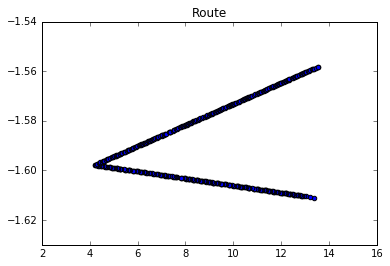

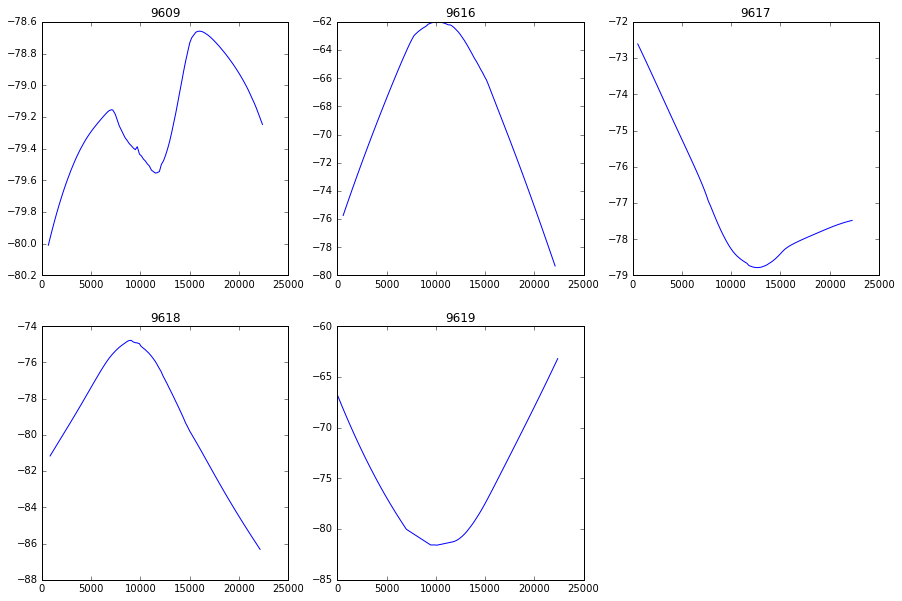

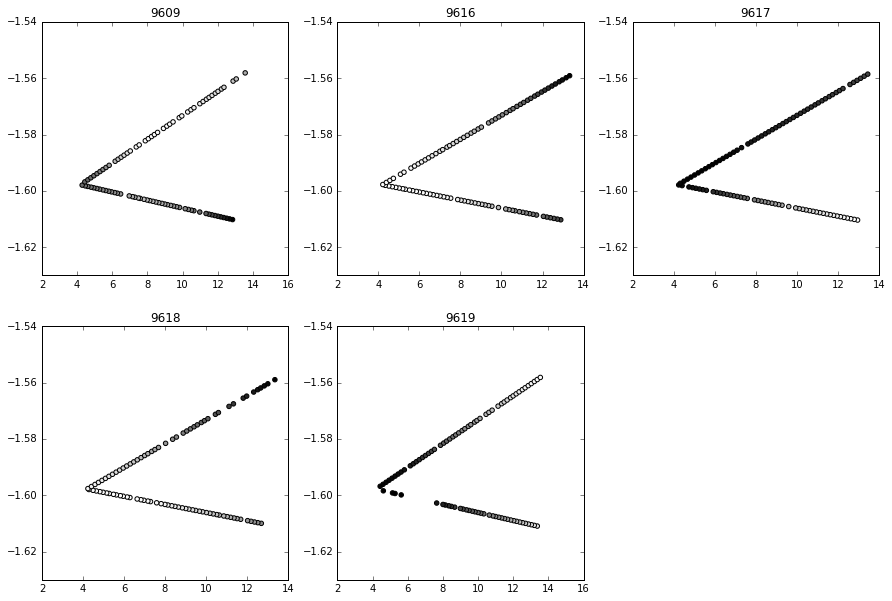

In [6]:
plot_session(straight_line, filter_func=create_rssi_median_filter(51))

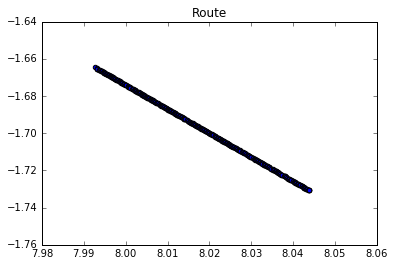

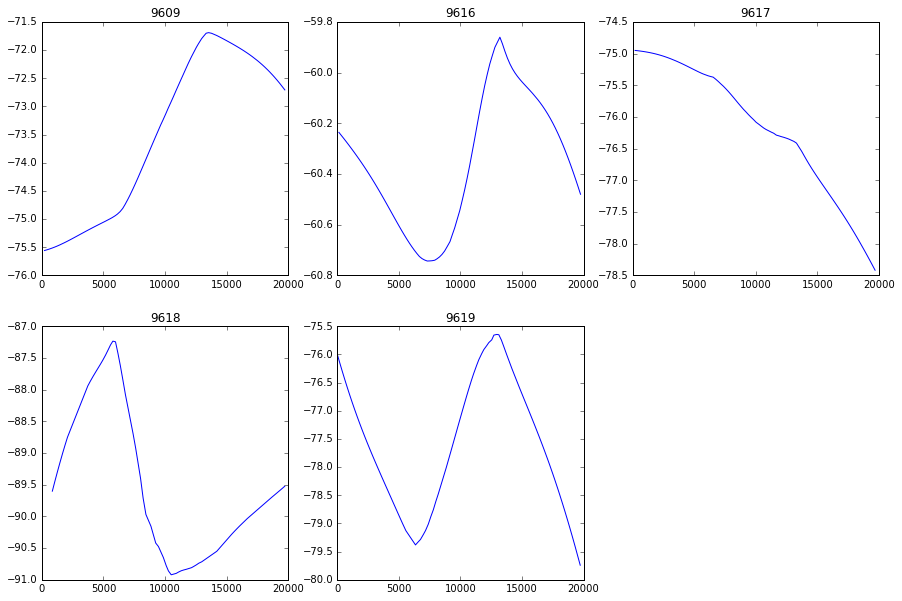

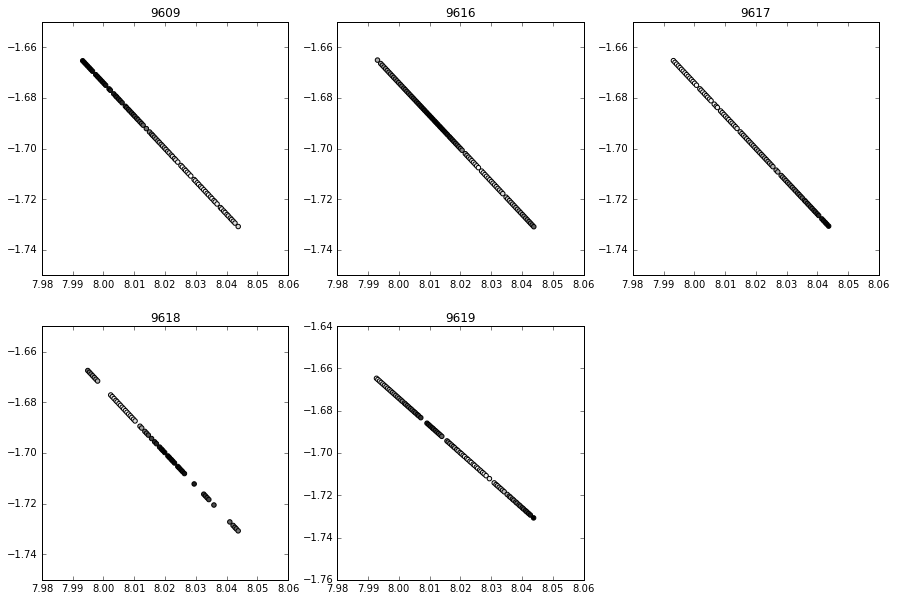

In [7]:
plot_session(standing_still, filter_func=create_rssi_median_filter(51))

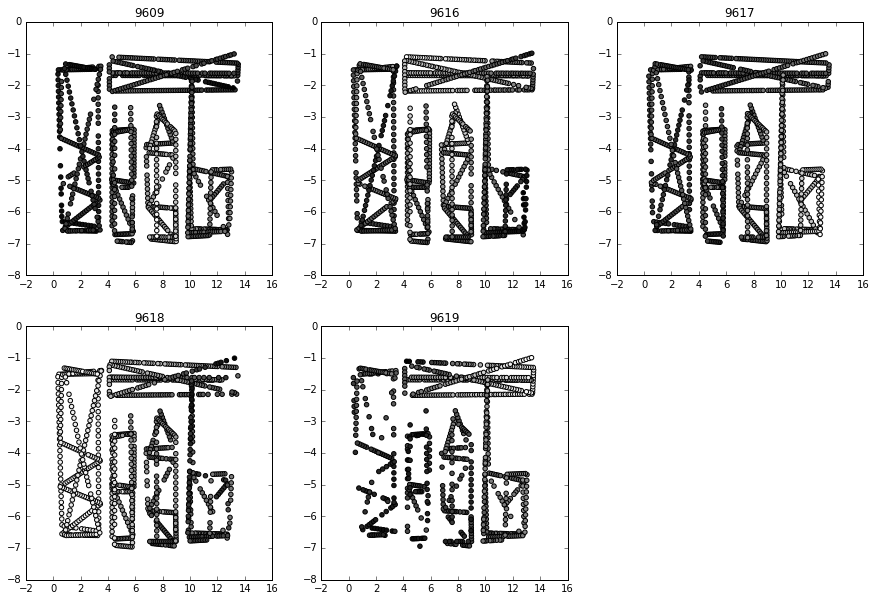

In [9]:
plot_rssi_map(df, filter_func=rssi_lowess_filter)

In [11]:
img = mpimg.imread('cropped_flat.png')

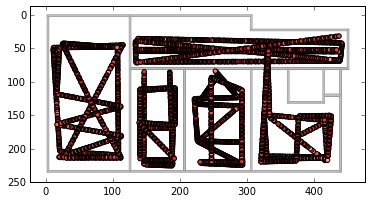

In [56]:
scatter_over_image(img, df.X, df.Y, c=-df.RSSI, cmap='Reds')

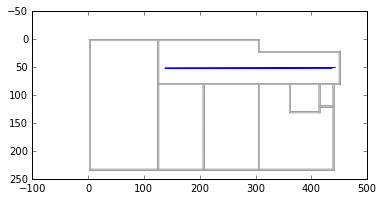

In [35]:
plot_over_image(img, straight_line.X, straight_line.Y)

In [51]:
def plot_over_image(img, x, y, **kwargs):
    scaleX = img.shape[1] / 13.9
    scaleY = img.shape[0] / 7.35
    plt.imshow(img)
    plt.plot(x * scaleX, y * scaleY, **kwargs)

In [52]:
def scatter_over_image(img, x, y, **kwargs):
    scaleX = img.shape[1] / 13.9
    scaleY = img.shape[0] / 7.35
    plt.imshow(img)
    plt.scatter(x * scaleX, y * scaleY, **kwargs)